#MODELLING  -  3rd iteration


Tests on-going on 10 genius with ~1000 images per genius. Different models tested with transfer learning, data augmentation, and fine tuning.
Hyper parameters tuning is tested in a separate notebook. 
Model interpretability with Grad-CAM algorithm added in the end 

# Introduction


### Settings

In [ ]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
# Settings
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

GDRIVE_MOUNT_POINT = '/content/drive'
PROJECT_DIR = GDRIVE_MOUNT_POINT + '/MyDrive/Mushroom_project' 
PY_LIB_DIR = PROJECT_DIR + '/src/lib'
SRC_DIR = PROJECT_DIR + '/datasource/mushroomObserver/dataframe/clean'

IMG_DIR=PROJECT_DIR + "/datasource/mushroomObserver/images"

WORK_DIR = "/content/drive/MyDrive/work/Oliv"
IMG_DIR = WORK_DIR + "/images"

WORK_DIR_DAD= "/content/drive/MyDrive/work/dad/transfert/images"


### Import libraries

In [ ]:
# Importing standard libraries
#
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import seaborn as sns

from keras import backend as K
from keras.preprocessing import image
from tensorflow.keras import models

import cv2
import matplotlib.cm as cm

from IPython.display import Image, display

import random

from sklearn import metrics
from sklearn.model_selection import train_test_split

 

In [ ]:
# Optional - Pre-requisites 
#
# Mounting Google drive if not already done
if not os.path.isdir(GDRIVE_MOUNT_POINT):
  drive.mount(GDRIVE_MOUNT_POINT)


Mounted at /content/drive


### Loading Data

In [ ]:
df_genus = pd.read_csv( \
      filepath_or_buffer = WORK_DIR + '/' + "df_genus.csv"
   ,  sep = ','
   ,  header = 0
)

#specify image link within Google Drive
#for i in range(len(df_genus)):
#  df_genus.loc[i,"img_path"]= WORK_DIR + "/" + df_genus.loc[i,"taxon_name"] + "/" + str(int(df_genus.loc[i,"image_id"]))+".jpg"


#filter specific nb of genus for test purposes

filtre_genus=['Amanita',
 'Armillaria',
 'Boletus',
 'Cantharellus',
 'Cortinarius',
 'Hygrocybe',
 'Russula',
 'Suillus',
 'Tricholoma',
 'Tylopilus']

#filtre_genus=["Russula",
#"Cortinarius",
#Psathyrella",
#"Mycena",
#"Agaricus",
#"Amanita",
#"Entoloma",
#"Lactarius",
#"Gymnopilus",
#"Pluteus"]

#filtre_genus=df_genus.taxon_name.value_counts().index[:]

t= df_genus.shape
df_genus=df_genus[df_genus["taxon_name"].isin(filtre_genus)].reset_index()

#Prepare train and test sets
X= df_genus[df_genus["taxon_name"].isin(filtre_genus)][["img_path","taxon_name"]]

#split the dataset between 80% train, 20% validation and 10% test)
X_train, X_test = train_test_split(X, test_size=0.2, random_state=1)
X_train, X_val= train_test_split(X_train, test_size=0.125, random_state=1)

print("shape : ", t)
print("shape X genus: ", X.shape)
print("shape train: ", X_train.shape)
print("shape test:", X_test.shape)
print("shape valid: ", X_val.shape)

X_train.reset_index(drop=True, inplace=True)
X_train.head()

shape :  (32387, 40)
shape X genus:  (9599, 2)
shape train:  (6719, 2)
shape test: (1920, 2)
shape valid:  (960, 2)


,img_path,taxon_name
0,/content/drive/MyDrive/work/Oliv/images/Russul...,Russula
1,/content/drive/MyDrive/work/Oliv/images/Boletu...,Boletus
2,/content/drive/MyDrive/work/Oliv/images/Russul...,Russula
3,/content/drive/MyDrive/work/Oliv/images/Russul...,Russula
4,/content/drive/MyDrive/work/Oliv/images/Cortin...,Cortinarius


In [ ]:
#Global Configuration

epochs= 30

batch_size=32


#Efficient Net B0

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=None

learning_rate=0.0001

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


Found 6719 validated image filenames belonging to 10 classes.
Found 1920 validated image filenames belonging to 10 classes.
Found 960 validated image filenames belonging to 10 classes.


Genre:  [4.0, 4.0, 9.0, 2.0, 4.0]


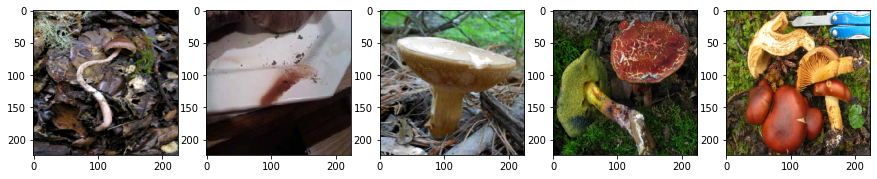

In [ ]:
#optionnal : visualise 5 pictures
mushroom=[next(train_generator) for i in range(0,5)]
fig,ax=plt.subplots(1,5, figsize=(15,6))
print("Genre: ", [item[1][0] for item in mushroom])
for i in range(0,5):
    ax[i].imshow(mushroom[i][0][0].astype("uint8"))


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x= inputs
base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable=False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
layers=[(layer,layer.name,layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=["layer type", "layer name", "layer trainable"])

Number of layers in the base model:  237


,layer type,layer name,layer trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_28,False
1,<tensorflow.python.keras.layers.preprocessing....,rescaling_23,False
2,<tensorflow.python.keras.layers.preprocessing....,normalization_23,False
3,<tensorflow.python.keras.layers.convolutional....,stem_conv_pad,False
4,<tensorflow.python.keras.layers.convolutional....,stem_conv,False
...,...,...,...
232,<tensorflow.python.keras.layers.convolutional....,block7a_project_conv,False
233,<tensorflow.python.keras.layers.normalization_...,block7a_project_bn,False
234,<tensorflow.python.keras.layers.convolutional....,top_conv,False
235,<tensorflow.python.keras.layers.normalization_...,top_bn,False


In [ ]:
#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#fit
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = 0.2
   , patience = 5   
   , min_lr = 0.00001
   , verbose = 1
)

# Create a callback that saves the model's weights
checkpoint_path = WORK_DIR + "/saved_model/" + "ENetB0_1.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callback = [cp_callback,  tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/30
210/210 [==============================] - 118s 312ms/step - loss: 2.2608 - accuracy: 0.1585 - top-2-accuracy: 0.2950 - val_loss: 2.0783 - val_accuracy: 0.2651 - val_top-2-accuracy: 0.4578

Epoch 00001: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_1.ckpt
Epoch 2/30
210/210 [==============================] - 64s 303ms/step - loss: 1.9957 - accuracy: 0.2983 - top-2-accuracy: 0.4853 - val_loss: 1.8792 - val_accuracy: 0.3859 - val_top-2-accuracy: 0.6021

Epoch 00002: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_1.ckpt
Epoch 3/30
210/210 [==============================] - 63s 301ms/step - loss: 1.8223 - accuracy: 0.3856 - top-2-accuracy: 0.5858 - val_loss: 1.7409 - val_accuracy: 0.4568 - val_top-2-accuracy: 0.6687

Epoch 00003: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_1.ckpt
Epoch 4/30
210/210 [==============================] - 63s 299ms/step - loss: 1.6968 - accuracy: 0.4452 - top-2-accuracy: 0.6540 - val_l

30/30 [==============================] - 7s 224ms/step - loss: 1.1159 - accuracy: 0.6292 - top-2-accuracy: 0.8073


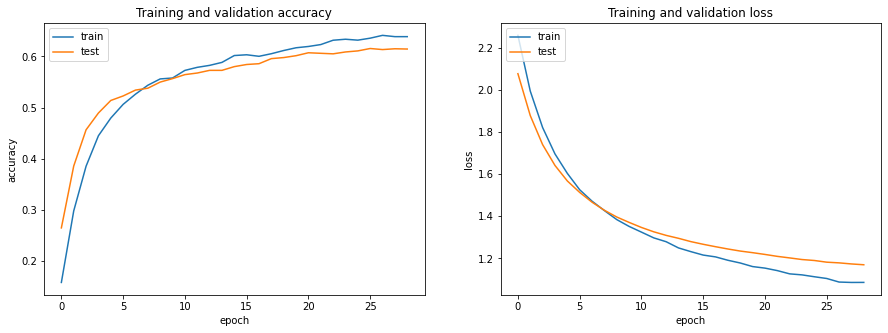

60/60 [==============================] - 15s 222ms/step
              precision    recall  f1-score   support

     Amanita       0.62      0.65      0.63       192
  Armillaria       0.60      0.55      0.58       186
     Boletus       0.65      0.58      0.61       210
Cantharellus       0.70      0.78      0.74       187
 Cortinarius       0.63      0.49      0.55       204
   Hygrocybe       0.85      0.81      0.83       214
     Russula       0.51      0.54      0.52       167
     Suillus       0.58      0.52      0.55       190
  Tricholoma       0.52      0.53      0.52       184
   Tylopilus       0.50      0.68      0.57       186

    accuracy                           0.61      1920
   macro avg       0.62      0.61      0.61      1920
weighted avg       0.62      0.61      0.61      1920



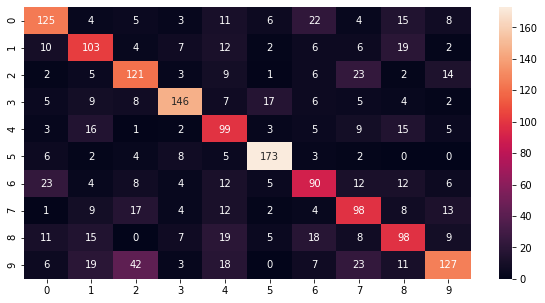

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/" + "ENetB0_1.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


This weird behavior comes from the BatchNormalization layer. It seems like there is a bug, when keras (2.2.4) is running the validation in inference mode. However we could ignore this, because besides the weird validation accuracy scores, our layer still learns, as we can see in the training accuracy (Read more about different normalization layers here). But to fix it, we can make the BatchNormalization layer trainable:

In [ ]:
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

At some point in the training progress, the model does not improve further and it’s time to open the rest of the network for fine-tune the feature extraction part. Therefore we make all the layers trainable and fit the model again. We can gain a few percentage points

In [ ]:
model.trainable= True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])
history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/30
210/210 [==============================] - 88s 377ms/step - loss: 1.4699 - accuracy: 0.4926 - top-2-accuracy: 0.6767 - val_loss: 1.2564 - val_accuracy: 0.5651 - val_top-2-accuracy: 0.7417

Epoch 00001: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_1.ckpt
Epoch 2/30
210/210 [==============================] - 77s 368ms/step - loss: 1.2772 - accuracy: 0.5599 - top-2-accuracy: 0.7436 - val_loss: 1.2334 - val_accuracy: 0.5708 - val_top-2-accuracy: 0.7563

Epoch 00002: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_1.ckpt
Epoch 3/30
210/210 [==============================] - 77s 367ms/step - loss: 1.1644 - accuracy: 0.6059 - top-2-accuracy: 0.7794 - val_loss: 1.1831 - val_accuracy: 0.5922 - val_top-2-accuracy: 0.7734

Epoch 00003: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_1.ckpt
Epoch 4/30
210/210 [==============================] - 77s 368ms/step - loss: 1.0945 - accuracy: 0.6279 - top-2-accuracy: 0.8001 - val_lo

30/30 [==============================] - 7s 229ms/step - loss: 0.7987 - accuracy: 0.7208 - top-2-accuracy: 0.8552


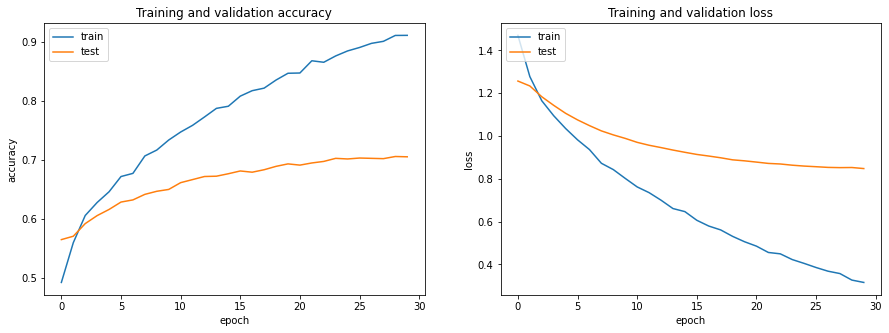

60/60 [==============================] - 15s 219ms/step
              precision    recall  f1-score   support

     Amanita       0.73      0.75      0.74       192
  Armillaria       0.65      0.66      0.66       186
     Boletus       0.73      0.63      0.68       210
Cantharellus       0.81      0.85      0.83       187
 Cortinarius       0.70      0.60      0.64       204
   Hygrocybe       0.84      0.86      0.85       214
     Russula       0.62      0.63      0.63       167
     Suillus       0.67      0.63      0.65       190
  Tricholoma       0.63      0.61      0.62       184
   Tylopilus       0.64      0.81      0.71       186

    accuracy                           0.71      1920
   macro avg       0.70      0.70      0.70      1920
weighted avg       0.71      0.71      0.70      1920



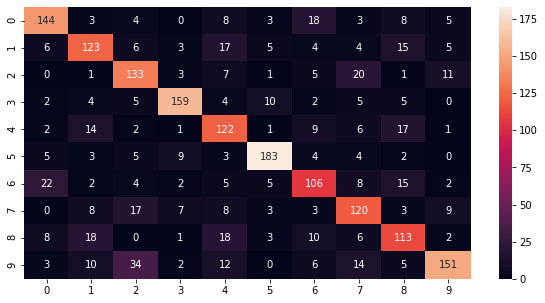

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

With data augmentation

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)
                    ])
x= data_augmentation(inputs)    #preprocessing treatments included in the model 

base_model = tf.keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor=x )

#build model
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

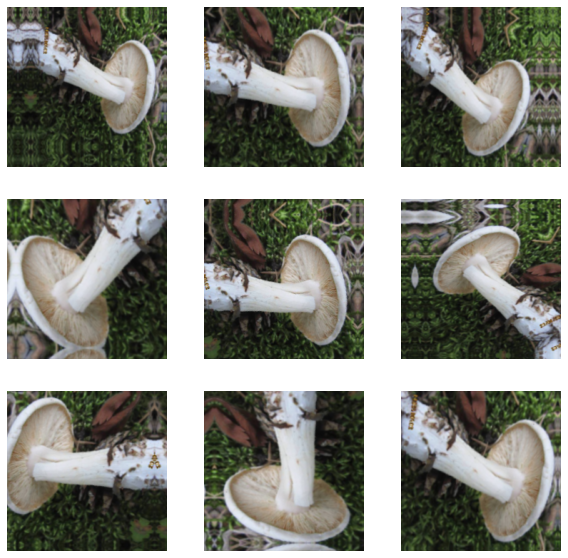

In [ ]:
#optionnal: To visualize the data augmentation 
for images in [next(train_generator) for i in range(0,1)]:
    plt.figure(figsize=(10, 10))
    first_image = images[0][0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        #plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#fit
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = 0.2
   , patience = 5   
   , min_lr = 0.00001
   , verbose = 1
)

# Create a callback that saves the model's weights
checkpoint_path = WORK_DIR + "/saved_model/" + "ENetB0_2.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callback = [ cp_callback,  tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]

history = model.fit(train_generator,
                    callbacks=[callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/30
210/210 [==============================] - 70s 297ms/step - loss: 1.8856 - accuracy: 0.3425 - top-2-accuracy: 0.5092 - val_loss: 1.3938 - val_accuracy: 0.5188 - val_top-2-accuracy: 0.7109

Epoch 00001: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_2.ckpt
Epoch 2/30
210/210 [==============================] - 61s 289ms/step - loss: 1.2543 - accuracy: 0.5679 - top-2-accuracy: 0.7492 - val_loss: 1.2020 - val_accuracy: 0.5859 - val_top-2-accuracy: 0.7573

Epoch 00002: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_2.ckpt
Epoch 3/30
210/210 [==============================] - 61s 290ms/step - loss: 1.0235 - accuracy: 0.6458 - top-2-accuracy: 0.8085 - val_loss: 1.1117 - val_accuracy: 0.6078 - val_top-2-accuracy: 0.7828

Epoch 00003: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_2.ckpt
Epoch 4/30
210/210 [==============================] - 61s 290ms/step - loss: 0.8791 - accuracy: 0.6977 - top-2-accuracy: 0.8461 - val_lo

30/30 [==============================] - 6s 197ms/step - loss: 1.1552 - accuracy: 0.7177 - top-2-accuracy: 0.8573


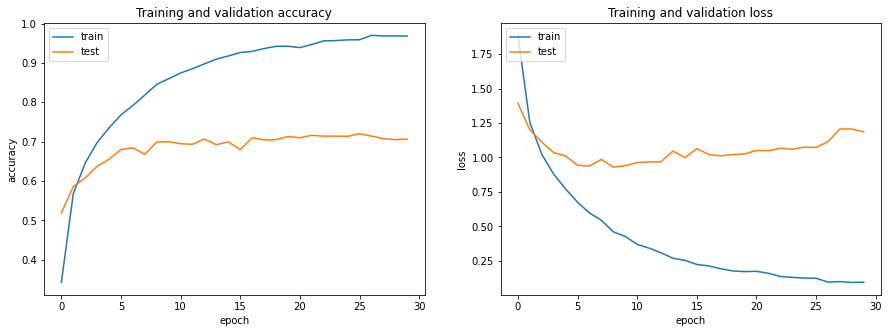

60/60 [==============================] - 12s 191ms/step
              precision    recall  f1-score   support

     Amanita       0.76      0.70      0.73       192
  Armillaria       0.70      0.68      0.69       186
     Boletus       0.62      0.79      0.69       210
Cantharellus       0.92      0.75      0.83       187
 Cortinarius       0.70      0.64      0.67       204
   Hygrocybe       0.75      0.90      0.82       214
     Russula       0.65      0.74      0.69       167
     Suillus       0.71      0.49      0.58       190
  Tricholoma       0.59      0.62      0.61       184
   Tylopilus       0.75      0.72      0.73       186

    accuracy                           0.71      1920
   macro avg       0.71      0.70      0.70      1920
weighted avg       0.71      0.71      0.70      1920



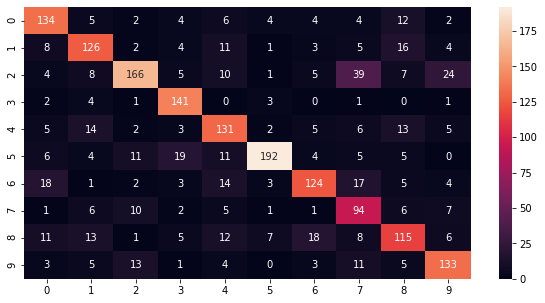

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

30/30 [==============================] - 6s 187ms/step
Path:  /content/drive/MyDrive/work/Oliv/images/Armillaria/21707.jpg
Path:  /content/drive/MyDrive/work/Oliv/images/Cantharellus/164053.jpg
Path:  /content/drive/MyDrive/work/Oliv/images/Suillus/576631.jpg
Path:  /content/drive/MyDrive/work/Oliv/images/Tricholoma/108291.jpg
Path:  /content/drive/MyDrive/work/Oliv/images/Boletus/90788.jpg


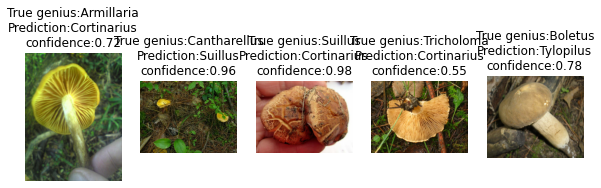

In [ ]:
show_wrong_predictions(model, val_generator)

Fine tuning the model

Importantly, although the base model becomes trainable, it is still running in inference mode since we passed training=False when calling it when we built the model. This means that the batch normalization layers inside won't update their batch statistics. If they did, they would wreck havoc on the representations learned by the model so far.

In [ ]:
#local configuration

fine_tune_at= 5   # Fine-tune from this layer onwards
ft_learning_rate= learning_rate/10
print(ft_learning_rate)
add_epochs= 5

1e-05


In [ ]:
#Fine tuning : unfreeze (all or) part of the model, retrain the model with a very low learning rate

model.trainable = True

# Let's take a look to see how many layers are in the base model
#print("Number of layers in the base model: ", len(base_model.layers))
#layers=[(layer,layer.name,layer.trainable) for layer in base_model.layers]
#pd.DataFrame(layers, columns=["layer type", "layer name", "layer trainable"])

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ft_learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#Fit
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = 0.2
   , patience = 5   
   , min_lr = 0.00001
   , verbose = 1
)

# Create a callback that saves the model's weights
checkpoint_path = WORK_DIR + "/saved_model/" + "ENetB0_3.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callback = [cp_callback,  tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)]
ENetB0_history_ft = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs+add_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=test_generator)


Epoch 30/35
210/210 [==============================] - 71s 300ms/step - loss: 0.0687 - accuracy: 0.9780 - top-2-accuracy: 0.9963 - val_loss: 1.0951 - val_accuracy: 0.7281 - val_top-2-accuracy: 0.8573

Epoch 00030: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_3.ckpt
Epoch 31/35
210/210 [==============================] - 62s 294ms/step - loss: 0.0608 - accuracy: 0.9824 - top-2-accuracy: 0.9981 - val_loss: 1.0867 - val_accuracy: 0.7312 - val_top-2-accuracy: 0.8578

Epoch 00031: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_3.ckpt
Epoch 32/35
210/210 [==============================] - 62s 294ms/step - loss: 0.0677 - accuracy: 0.9792 - top-2-accuracy: 0.9973 - val_loss: 1.0987 - val_accuracy: 0.7312 - val_top-2-accuracy: 0.8552

Epoch 00032: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB0_3.ckpt
Epoch 33/35
210/210 [==============================] - 61s 292ms/step - loss: 0.0647 - accuracy: 0.9784 - top-2-accuracy: 0.9969 - va

30/30 [==============================] - 6s 199ms/step - loss: 1.1185 - accuracy: 0.7156 - top-2-accuracy: 0.8594


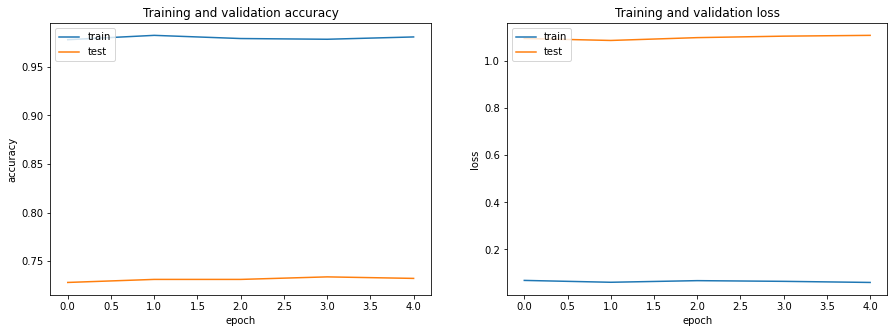

60/60 [==============================] - 13s 190ms/step
              precision    recall  f1-score   support

     Amanita       0.80      0.71      0.75       192
  Armillaria       0.72      0.69      0.70       186
     Boletus       0.70      0.71      0.71       210
Cantharellus       0.91      0.81      0.86       187
 Cortinarius       0.74      0.67      0.70       204
   Hygrocybe       0.81      0.89      0.85       214
     Russula       0.70      0.77      0.74       167
     Suillus       0.70      0.56      0.62       190
  Tricholoma       0.59      0.66      0.62       184
   Tylopilus       0.69      0.84      0.76       186

    accuracy                           0.73      1920
   macro avg       0.73      0.73      0.73      1920
weighted avg       0.74      0.73      0.73      1920



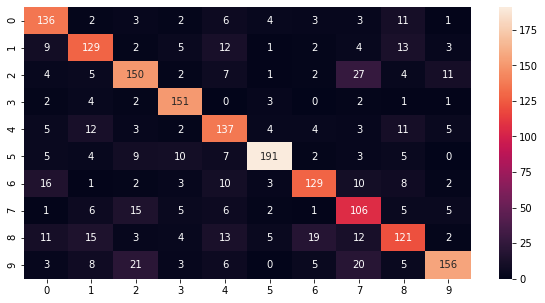

In [ ]:
#evaluate
model.evaluate(val_generator)

show_performance(model, ENetB0_history_ft)

In [ ]:
model.summary()

#Efficient Net B1


In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=None

learning_rate=0.0001

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


Found 6719 validated image filenames belonging to 10 classes.
Found 1920 validated image filenames belonging to 10 classes.
Found 960 validated image filenames belonging to 10 classes.


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x= inputs
base_model = tf.keras.applications.EfficientNetB1(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable= False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

27025408/27018416 [==============================] - 1s 0us/step


In [ ]:
#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#fit
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = 0.2
   , patience = 5   
   , min_lr = 0.00001
   , verbose = 1
)

# Create a callback that saves the model's weights
checkpoint_path = WORK_DIR + "/saved_model/" + "ENetB1_1.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callback = [cp_callback,  tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/30
210/210 [==============================] - 5417s 26s/step - loss: 2.2652 - accuracy: 0.1715 - top-2-accuracy: 0.3128 - val_loss: 2.0892 - val_accuracy: 0.2771 - val_top-2-accuracy: 0.4630

Epoch 00001: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB1_1.ckpt
Epoch 2/30
210/210 [==============================] - 54s 258ms/step - loss: 1.9914 - accuracy: 0.3124 - top-2-accuracy: 0.5019 - val_loss: 1.8792 - val_accuracy: 0.4031 - val_top-2-accuracy: 0.5990

Epoch 00002: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB1_1.ckpt
Epoch 3/30
210/210 [==============================] - 54s 256ms/step - loss: 1.8105 - accuracy: 0.4015 - top-2-accuracy: 0.6049 - val_loss: 1.7370 - val_accuracy: 0.4672 - val_top-2-accuracy: 0.6557

Epoch 00003: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB1_1.ckpt
Epoch 4/30
210/210 [==============================] - 54s 258ms/step - loss: 1.6857 - accuracy: 0.4516 - top-2-accuracy: 0.6534 - val_lo

30/30 [==============================] - 586s 20s/step - loss: 1.1348 - accuracy: 0.6281 - top-2-accuracy: 0.8094


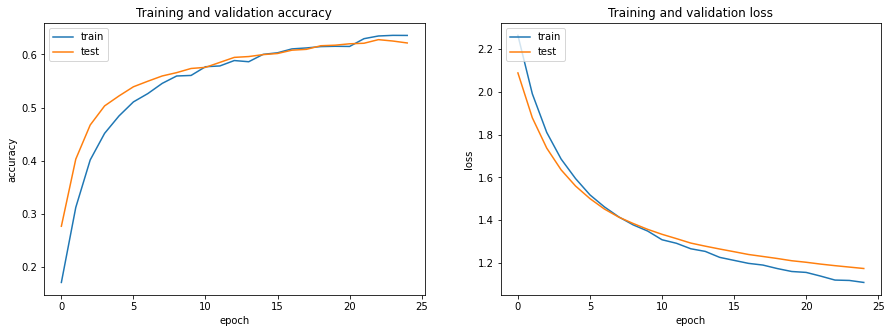

60/60 [==============================] - 13s 195ms/step
              precision    recall  f1-score   support

     Amanita       0.64      0.66      0.65       192
  Armillaria       0.58      0.59      0.58       186
     Boletus       0.64      0.55      0.59       210
Cantharellus       0.73      0.80      0.76       187
 Cortinarius       0.55      0.42      0.47       204
   Hygrocybe       0.82      0.80      0.81       214
     Russula       0.56      0.53      0.55       167
     Suillus       0.62      0.58      0.60       190
  Tricholoma       0.56      0.53      0.54       184
   Tylopilus       0.52      0.74      0.61       186

    accuracy                           0.62      1920
   macro avg       0.62      0.62      0.62      1920
weighted avg       0.62      0.62      0.62      1920



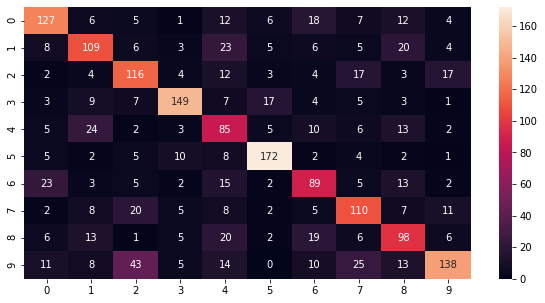

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/" + "ENetB1_1.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
model.trainable= True

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate/10),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])
history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/30
210/210 [==============================] - 80s 325ms/step - loss: 1.5685 - accuracy: 0.4621 - top-2-accuracy: 0.6546 - val_loss: 1.3142 - val_accuracy: 0.5641 - val_top-2-accuracy: 0.7323

Epoch 00001: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB1_1.ckpt
Epoch 2/30
210/210 [==============================] - 66s 314ms/step - loss: 1.3726 - accuracy: 0.5374 - top-2-accuracy: 0.7162 - val_loss: 1.2979 - val_accuracy: 0.5646 - val_top-2-accuracy: 0.7323

Epoch 00002: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB1_1.ckpt
Epoch 3/30
210/210 [==============================] - 66s 313ms/step - loss: 1.2501 - accuracy: 0.5779 - top-2-accuracy: 0.7471 - val_loss: 1.2404 - val_accuracy: 0.5813 - val_top-2-accuracy: 0.7401

Epoch 00003: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB1_1.ckpt
Epoch 4/30
210/210 [==============================] - 66s 314ms/step - loss: 1.1515 - accuracy: 0.6120 - top-2-accuracy: 0.7811 - val_lo

30/30 [==============================] - 6s 197ms/step - loss: 0.7905 - accuracy: 0.7375 - top-2-accuracy: 0.8771


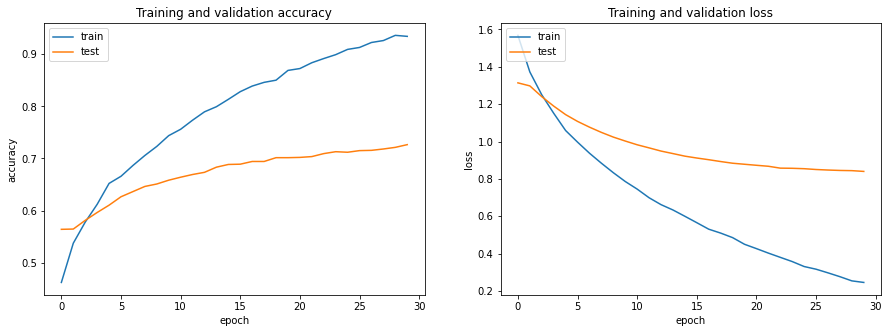

60/60 [==============================] - 13s 197ms/step
              precision    recall  f1-score   support

     Amanita       0.75      0.77      0.76       192
  Armillaria       0.66      0.73      0.69       186
     Boletus       0.74      0.67      0.70       210
Cantharellus       0.81      0.83      0.82       187
 Cortinarius       0.69      0.62      0.65       204
   Hygrocybe       0.85      0.84      0.85       214
     Russula       0.71      0.69      0.70       167
     Suillus       0.67      0.64      0.66       190
  Tricholoma       0.67      0.62      0.65       184
   Tylopilus       0.70      0.84      0.76       186

    accuracy                           0.73      1920
   macro avg       0.73      0.73      0.72      1920
weighted avg       0.73      0.73      0.73      1920



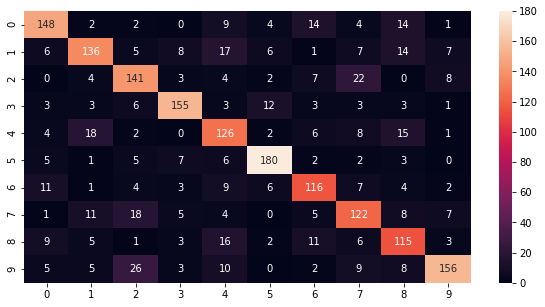

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

30/30 [==============================] - 6s 192ms/step
Path:  /content/drive/MyDrive/work/Oliv/images/Suillus/27667.jpg
Path:  /content/drive/MyDrive/work/Oliv/images/Suillus/643178.jpg
Path:  /content/drive/MyDrive/work/Oliv/images/Boletus/274652.jpg
Path:  /content/drive/MyDrive/work/Oliv/images/Suillus/375922.jpg
Path:  /content/drive/MyDrive/work/Oliv/images/Armillaria/134185.jpg


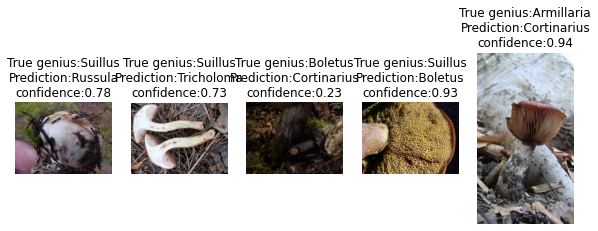

In [ ]:
show_wrong_predictions(model, val_generator)

#Efficient Net B5

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

preprocess_input=None

learning_rate=0.0001

In [ ]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="",       
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)

list_genus=[]
for i,j in train_generator.class_indices.items():
  list_genus.append(i)


Found 6719 validated image filenames belonging to 10 classes.
Found 1920 validated image filenames belonging to 10 classes.
Found 960 validated image filenames belonging to 10 classes.


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x= inputs
base_model = tf.keras.applications.EfficientNetB5(include_top=False, weights="imagenet", input_tensor=x )

#build model
base_model.trainable = False
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
#model.summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_16 (Rescaling)        (None, 224, 224, 3)  0           input_17[0][0]                   
__________________________________________________________________________________________________
normalization_16 (Normalization (None, 224, 224, 3)  7           rescaling_16[0][0]               
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_16[0][0]           
___________________________________________________________________________________________

In [ ]:
#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#fit
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = 0.2
   , patience = 5   
   , min_lr = 0.0001
   , verbose = 1
)

# Create a callback that saves the model's weights
checkpoint_path = WORK_DIR + "/saved_model/" + "ENetB5_1.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callback = [cp_callback,  tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)]

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/30
210/210 [==============================] - 90s 357ms/step - loss: 2.1796 - accuracy: 0.2088 - top-2-accuracy: 0.3660 - val_loss: 2.0121 - val_accuracy: 0.3021 - val_top-2-accuracy: 0.5000

Epoch 00001: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB5_1.ckpt
Epoch 2/30
210/210 [==============================] - 71s 340ms/step - loss: 1.9298 - accuracy: 0.3359 - top-2-accuracy: 0.5477 - val_loss: 1.8309 - val_accuracy: 0.3969 - val_top-2-accuracy: 0.5891

Epoch 00002: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB5_1.ckpt
Epoch 3/30
210/210 [==============================] - 71s 337ms/step - loss: 1.7798 - accuracy: 0.4081 - top-2-accuracy: 0.6184 - val_loss: 1.7189 - val_accuracy: 0.4464 - val_top-2-accuracy: 0.6359

Epoch 00003: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB5_1.ckpt
Epoch 4/30
210/210 [==============================] - 71s 337ms/step - loss: 1.6801 - accuracy: 0.4407 - top-2-accuracy: 0.6489 - val_lo

30/30 [==============================] - 8s 274ms/step - loss: 1.2170 - accuracy: 0.6031 - top-2-accuracy: 0.7729


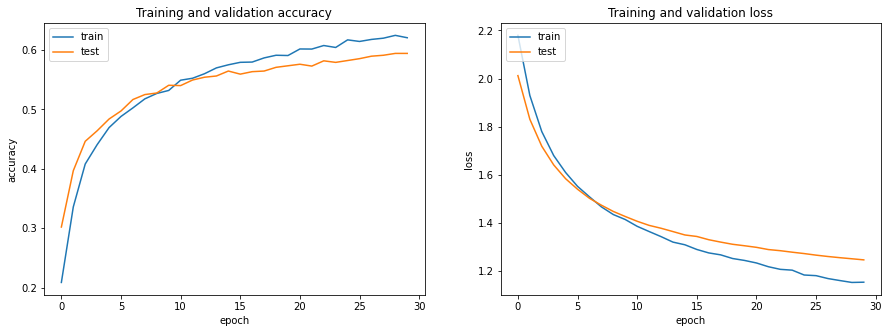

60/60 [==============================] - 17s 234ms/step
              precision    recall  f1-score   support

     Amanita       0.66      0.67      0.67       192
  Armillaria       0.53      0.58      0.55       186
     Boletus       0.65      0.54      0.59       210
Cantharellus       0.68      0.71      0.69       187
 Cortinarius       0.51      0.44      0.47       204
   Hygrocybe       0.80      0.77      0.79       214
     Russula       0.47      0.53      0.49       167
     Suillus       0.51      0.56      0.54       190
  Tricholoma       0.56      0.47      0.51       184
   Tylopilus       0.57      0.67      0.61       186

    accuracy                           0.59      1920
   macro avg       0.59      0.59      0.59      1920
weighted avg       0.60      0.59      0.59      1920



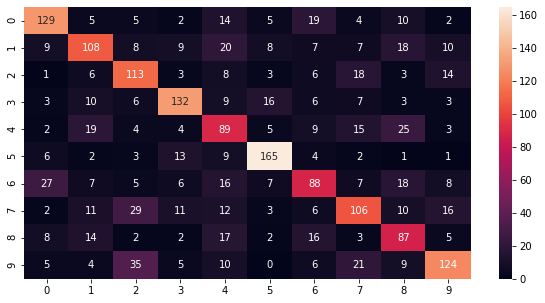

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save(WORK_DIR+ "/saved_model/" + "ENetB5_1.h5")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [ ]:
print(model.summary())

In [ ]:
#Fine tuning : unfreezing part of the layers
#local configuration

fine_tune_at=50    # Fine-tune from this layer onwards
ft_learning_rate= learning_rate/10
print(ft_learning_rate)
add_epochs= 5

1e-05


In [ ]:
#Fine tuning : unfreeze (all or) part of the model, retrain the model with a very low learning rate

model.trainable = True

# Let's take a look to see how many layers are in the base model
#print("Number of layers in the base model: ", len(base_model.layers))
#layers=[(layer,layer.name,layer.trainable) for layer in base_model.layers]
#pd.DataFrame(layers, columns=["layer type", "layer name", "layer trainable"])

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable =  False
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=ft_learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
model.summary()

In [ ]:
#Fit
reduceLEarningRate_clbck = tf.keras.callbacks.ReduceLROnPlateau(
     monitor = 'val_loss'
   , factor = 0.2
   , patience = 5   
   , min_lr = 0.00001
   , verbose = 1
)

# Create a callback that saves the model's weights
checkpoint_path = WORK_DIR + "/saved_model/" + "ENetB5_2.ckpt"
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

callback = [cp_callback,  tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)]
history_ft = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs+add_epochs,
                    initial_epoch=history.epoch[-1],
                    validation_data=test_generator)


Epoch 30/35
210/210 [==============================] - 149s 590ms/step - loss: 0.5120 - accuracy: 0.8413 - top-2-accuracy: 0.9359 - val_loss: 1.0568 - val_accuracy: 0.6443 - val_top-2-accuracy: 0.7875

Epoch 00030: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB5_2.ckpt
Epoch 31/35
210/210 [==============================] - 120s 572ms/step - loss: 0.4273 - accuracy: 0.8775 - top-2-accuracy: 0.9543 - val_loss: 1.0536 - val_accuracy: 0.6453 - val_top-2-accuracy: 0.7870

Epoch 00031: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB5_2.ckpt
Epoch 32/35
210/210 [==============================] - 120s 573ms/step - loss: 0.3803 - accuracy: 0.8928 - top-2-accuracy: 0.9647 - val_loss: 1.0443 - val_accuracy: 0.6500 - val_top-2-accuracy: 0.7917

Epoch 00032: saving model to /content/drive/MyDrive/work/Oliv/saved_model/ENetB5_2.ckpt
Epoch 33/35
210/210 [==============================] - 120s 572ms/step - loss: 0.3165 - accuracy: 0.9228 - top-2-accuracy: 0.9763 

30/30 [==============================] - 8s 267ms/step - loss: 0.9915 - accuracy: 0.6865 - top-2-accuracy: 0.8167


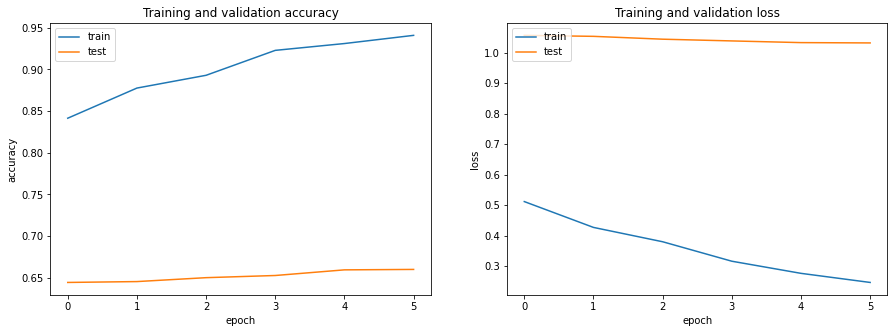

60/60 [==============================] - 18s 237ms/step
              precision    recall  f1-score   support

     Amanita       0.70      0.73      0.71       192
  Armillaria       0.63      0.68      0.65       186
     Boletus       0.66      0.61      0.63       210
Cantharellus       0.74      0.78      0.76       187
 Cortinarius       0.60      0.58      0.59       204
   Hygrocybe       0.81      0.81      0.81       214
     Russula       0.56      0.55      0.56       167
     Suillus       0.66      0.56      0.60       190
  Tricholoma       0.59      0.56      0.58       184
   Tylopilus       0.61      0.72      0.66       186

    accuracy                           0.66      1920
   macro avg       0.66      0.66      0.66      1920
weighted avg       0.66      0.66      0.66      1920



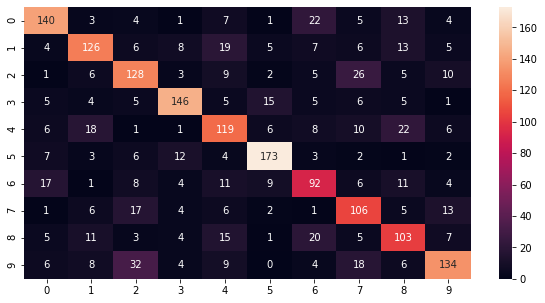

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history_ft)

# VGG16

We start with a basic VGG16 

In [ ]:
#Model Configuration

IMG_SIZE=(224,224)

pp_input=tf.keras.applications.vgg16.preprocess_input

learning_rate=0.01

epochs=10

In [ ]:
# VGG16 model also expects images to be centered. That is,
# to have the mean pixel values from each channel (red, green, and blue) 
# as calculated on the ImageNet training dataset subtracted from the input. 
# Keras provides a function to perform this preparation for individual photos
# via the preprocess_input() function. Nevertheless, we can achieve the same
# effect with the ImageDataGenerator by setting the “featurewise_center” argument
# to “True” and manually specifying the mean pixel values to use when centering
# as the mean values from the ImageNet training dataset: [123.68, 116.779, 103.939].

#datagen= keras.preprocessing.image.ImageDataGenerator(featurewise_center=True)
#datagen.mean = [123.68, 116.779, 103.939]


datagen= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pp_input)
train_generator= datagen.flow_from_dataframe(dataframe=X_train, directory="", 
                                             x_col="img_path", y_col="taxon_name",
                                             class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)
test_generator= datagen.flow_from_dataframe(dataframe=X_test, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)    
val_generator= datagen.flow_from_dataframe(dataframe=X_val, directory="",
                                            x_col="img_path", y_col="taxon_name", shuffle=False,
                                            class_mode="sparse", target_size=IMG_SIZE, batch_size=batch_size)


Found 6719 validated image filenames belonging to 10 classes.
Found 1920 validated image filenames belonging to 10 classes.
Found 960 validated image filenames belonging to 10 classes.


In [ ]:
mushroom=[next(train_generator) for i in range(0,5)]
fig,ax=plt.subplots(1,5, figsize=(15,6))
print("Genre: ", [item[1][0] for item in mushroom])
for i in range(0,5):
  ax[i].imshow(mushroom[i][0][0].astype("uint8"))


In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
x= inputs
base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False, input_tensor=x)
for layer in base_model.layers:
    layer.trainable= False
#build modelb
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [ ]:
#compile  
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#fit
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/10
210/210 [==============================] - 70s 329ms/step - loss: 5.8042 - accuracy: 0.3764 - top-2-accuracy: 0.5665 - val_loss: 4.0043 - val_accuracy: 0.4563 - val_top-2-accuracy: 0.6714
Epoch 2/10
210/210 [==============================] - 68s 325ms/step - loss: 4.5164 - accuracy: 0.4594 - top-2-accuracy: 0.6458 - val_loss: 4.0156 - val_accuracy: 0.4818 - val_top-2-accuracy: 0.6682
Epoch 3/10
210/210 [==============================] - 68s 322ms/step - loss: 5.0007 - accuracy: 0.4581 - top-2-accuracy: 0.6575 - val_loss: 5.1483 - val_accuracy: 0.4495 - val_top-2-accuracy: 0.6479
Epoch 4/10
210/210 [==============================] - 67s 319ms/step - loss: 5.1994 - accuracy: 0.4645 - top-2-accuracy: 0.6562 - val_loss: 4.8834 - val_accuracy: 0.4609 - val_top-2-accuracy: 0.6521
Epoch 5/10
210/210 [==============================] - 67s 318ms/step - loss: 4.8433 - accuracy: 0.4871 - top-2-accuracy: 0.6848 - val_loss: 4.6834 - val_accuracy: 0.4896 - val_top-2-accuracy: 0.6812
Epoch

30/30 [==============================] - 8s 254ms/step - loss: 4.0817 - accuracy: 0.5271 - top-2-accuracy: 0.7021


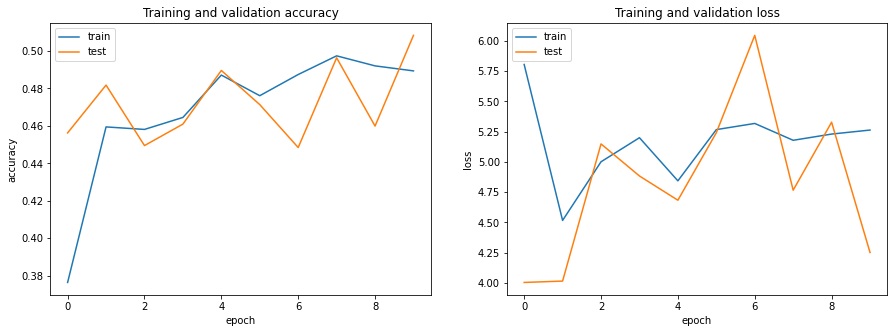

60/60 [==============================] - 14s 226ms/step
              precision    recall  f1-score   support

     Amanita       0.56      0.42      0.48       192
  Armillaria       0.41      0.47      0.44       186
     Boletus       0.51      0.60      0.55       210
Cantharellus       0.65      0.61      0.63       187
 Cortinarius       0.36      0.50      0.41       204
   Hygrocybe       0.78      0.66      0.72       214
     Russula       0.48      0.51      0.50       167
     Suillus       0.53      0.40      0.46       190
  Tricholoma       0.36      0.44      0.39       184
   Tylopilus       0.63      0.45      0.52       186

    accuracy                           0.51      1920
   macro avg       0.53      0.51      0.51      1920
weighted avg       0.53      0.51      0.51      1920



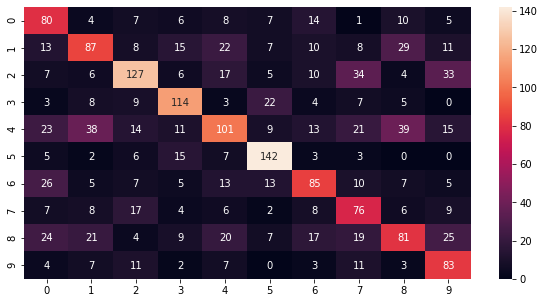

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,history)

In [ ]:
model.save(WORK_DIR+ "/saved_model/" + "VGG16_1.h5")

With data augmentation

In [ ]:
IMG_SHAPE = IMG_SIZE + (3,)

inputs = tf.keras.Input(shape=IMG_SHAPE)
data_augmentation = tf.keras.Sequential([
                    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
                    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
                    tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1)
                    ])
x= data_augmentation(inputs)

base_model = tf.keras.applications.VGG16(weights="imagenet", include_top=False,input_tensor=x)

for layer in base_model.layers:
    layer.trainable= False

#build model
x = base_model(x, training=False) #freeze the layers
x = base_model.output   
#add new model on top
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = tf.keras.layers.Dense(len(filtre_genus),activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
#optionnal: To visualize the data augmentation 
for images in [next(train_generator) for i in range(0,5)]:
    plt.figure(figsize=(10, 10))
    first_image = images[0][0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        #plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0001),  #learning rate !!
                  loss="sparse_categorical_crossentropy",
                  metrics=[
                           tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                           tf.keras.metrics.SparseTopKCategoricalAccuracy(2, name="top-2-accuracy"),
                           #tf.keras.metrics.SparseTopKCategoricalAccuracy(3, name="top-3-accuracy"),
                  ])

In [ ]:
#fit
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

VGG16_history = model.fit(train_generator,
                    callbacks= [callback],
                    epochs=epochs,
                    validation_data=test_generator)

Epoch 1/30
210/210 [==============================] - 59s 275ms/step - loss: 6.8038 - accuracy: 0.1161 - top-2-accuracy: 0.2210 - val_loss: 6.4834 - val_accuracy: 0.1437 - val_top-2-accuracy: 0.2620
Epoch 2/30
210/210 [==============================] - 58s 275ms/step - loss: 5.7786 - accuracy: 0.1405 - top-2-accuracy: 0.2627 - val_loss: 5.4073 - val_accuracy: 0.1786 - val_top-2-accuracy: 0.3214
Epoch 3/30
210/210 [==============================] - 58s 276ms/step - loss: 4.9711 - accuracy: 0.1726 - top-2-accuracy: 0.3112 - val_loss: 4.6442 - val_accuracy: 0.2062 - val_top-2-accuracy: 0.3661
Epoch 4/30
210/210 [==============================] - 58s 275ms/step - loss: 4.4614 - accuracy: 0.2109 - top-2-accuracy: 0.3544 - val_loss: 4.1390 - val_accuracy: 0.2448 - val_top-2-accuracy: 0.4266
Epoch 5/30
210/210 [==============================] - 58s 276ms/step - loss: 4.0843 - accuracy: 0.2206 - top-2-accuracy: 0.3829 - val_loss: 3.7028 - val_accuracy: 0.2729 - val_top-2-accuracy: 0.4771
Epoch

30/30 [==============================] - 6s 215ms/step - loss: 1.6587 - accuracy: 0.5167 - top-2-accuracy: 0.6896


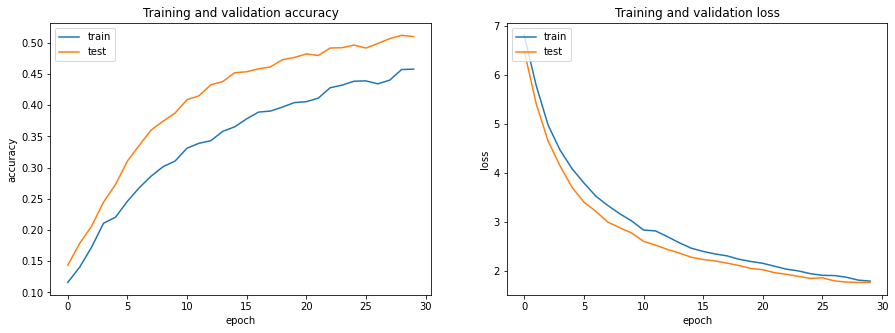

60/60 [==============================] - 13s 208ms/step
              precision    recall  f1-score   support

     Amanita       0.52      0.50      0.51       192
  Armillaria       0.46      0.32      0.38       186
     Boletus       0.58      0.53      0.55       210
Cantharellus       0.61      0.62      0.62       187
 Cortinarius       0.44      0.34      0.38       204
   Hygrocybe       0.76      0.71      0.73       214
     Russula       0.41      0.56      0.47       167
     Suillus       0.54      0.39      0.45       190
  Tricholoma       0.40      0.41      0.40       184
   Tylopilus       0.42      0.70      0.53       186

    accuracy                           0.51      1920
   macro avg       0.51      0.51      0.50      1920
weighted avg       0.52      0.51      0.51      1920



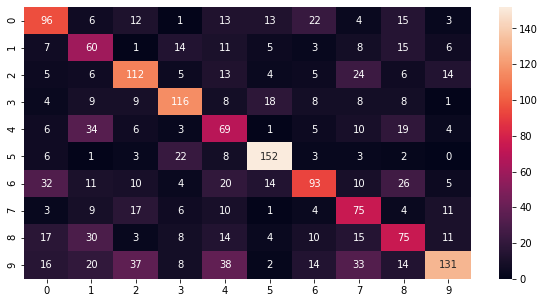

In [ ]:
#evaluate
model.evaluate(val_generator)
show_performance(model,VGG16_history)

Fine tuning

In [ ]:
model.summary()

Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))
layers=[(layer,layer.name,layer.trainable) for layer in base_model.layers]
pd.DataFrame(layers, columns=["layer type", "layer name", "layer trainable"])

Number of layers in the base model:  19


,layer type,layer name,layer trainable
0,<tensorflow.python.keras.engine.input_layer.In...,input_21,False
1,<tensorflow.python.keras.layers.convolutional....,block1_conv1,False
2,<tensorflow.python.keras.layers.convolutional....,block1_conv2,False
3,<tensorflow.python.keras.layers.pooling.MaxPoo...,block1_pool,False
4,<tensorflow.python.keras.layers.convolutional....,block2_conv1,False
5,<tensorflow.python.keras.layers.convolutional....,block2_conv2,False
6,<tensorflow.python.keras.layers.pooling.MaxPoo...,block2_pool,False
7,<tensorflow.python.keras.layers.convolutional....,block3_conv1,False
8,<tensorflow.python.keras.layers.convolutional....,block3_conv2,False
9,<tensorflow.python.keras.layers.convolutional....,block3_conv3,False


#Diagnostics functions

In [ ]:
#show model performance
def show_performance(my_model,history):
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  x_epochs=range(len(history.history["accuracy"]))
  plt.plot(x_epochs, history.history["accuracy"])
  plt.plot(x_epochs, history.history["val_accuracy"])
  plt.title("Training and validation accuracy")
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.subplot(1,2,2)
  x_epochs=range(len(history.history["loss"]))
  plt.plot(x_epochs, history.history["loss"])
  plt.plot(x_epochs, history.history["val_loss"])
  plt.title("Training and validation loss")
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes
  print(metrics.classification_report(y_test_class, test_pred_class, target_names=list_genus))
  df_cm=pd.DataFrame(metrics.confusion_matrix(test_pred_class,y_test_class))
  plt.figure(figsize = (10,5))
  sns.heatmap(df_cm, annot=True, fmt="d")


In [ ]:
def show_good_predictions(preprocess_input):
  
  correct_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] == y_test_class[i]):
      correct_indexes.append(i)

  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(correct_indexes, size=3):
    img=cv2.imread(X_test.img_path.iloc[i])
    plt.subplot(1,3,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(y_test_class[i]) +
              "\n"+ "Prediction:" + str(test_pred_class[i]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))

In [ ]:
#Show wrong predictions
def show_wrong_predictions(my_model, test_generator):
  test_pred=my_model.predict(x=test_generator, verbose=1)
  test_pred_class=test_pred.argmax(axis=1)
  #y_test_class=pd.get_dummies(X_test.taxon_name).to_numpy().argmax(axis=1)
  y_test_class=test_generator.classes

  error_indexes=[]
  for i in range(len(test_generator.filenames)):
    if(test_pred_class[i] != y_test_class[i]):
      error_indexes.append(i)
  j=1
  plt.figure(figsize=(10, 10))
  for i in np.random.choice(error_indexes, size=5):
    #img=cv2.imread(X_test.img_path.iloc[i])
    img=tf.io.read_file(test_generator.filenames[i])
    img=tf.image.decode_jpeg(img,channels=3)
    plt.subplot(1,5,j)
    j+=1
    plt.axis("off")
    plt.imshow(img )
    plt.title("True genius:" + str(list_genus[y_test_class[i]]) +
              "\n"+ "Prediction:" + str(list_genus[test_pred_class[i]]) + 
              "\n"+ "confidence:" + str(round(test_pred[i][test_pred_class[i]],2)))
    print("Path: ", test_generator.filenames[i])


# Interpretability

In [ ]:
#Grad-CAM algorithm to obtain a class activation heatmap

def get_img_array(img_path, size):
    # `img` is a PIL image of size XxX
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (X, X, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, X, X, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))




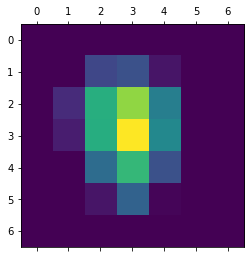

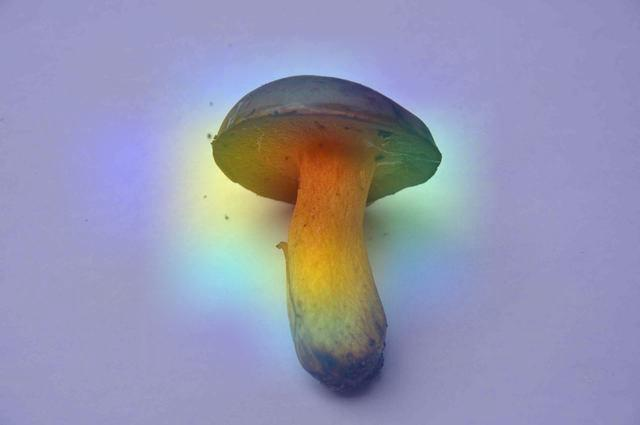

In [ ]:
img_path= X_train["img_path"][105]
#img_path= "/content/drive/MyDrive/work/Oliv/images/Tylopilus/58635.jpg"

decode_predictions = tf.keras.applications.efficientnet.decode_predictions
model_builder = tf.keras.applications.efficientnet.EfficientNetB0
model= tf.keras.models.load_model(WORK_DIR+ "/saved_model/" + "ENetB0.h5")
last_conv_layer_name = 'block7a_project_conv'

# Prepare image

img_array = get_img_array(img_path, size=IMG_SIZE)

# Make model
model = model_builder(weights="imagenet")

# Remove last layer's softmax
model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)
plt.show()

save_and_display_gradcam(img_path, heatmap)